<a href="https://colab.research.google.com/github/ykato27/Image-Classification/blob/main/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-gradcam

In [2]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

解析用に画像を取得

In [3]:
!wget https://raw.githubusercontent.com/vickyliin/gradcam_plus_plus-pytorch/master/images/water-bird.JPEG

--2021-06-06 03:39:16--  https://raw.githubusercontent.com/vickyliin/gradcam_plus_plus-pytorch/master/images/water-bird.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135167 (132K) [image/jpeg]
Saving to: ‘water-bird.JPEG.1’

water-bird.JPEG.1   100%[===================>] 132.00K  --.-KB/s    in 0.004s  

2021-06-06 03:39:16 (36.3 MB/s) - ‘water-bird.JPEG.1’ saved [135167/135167]



解析用の画像を確認

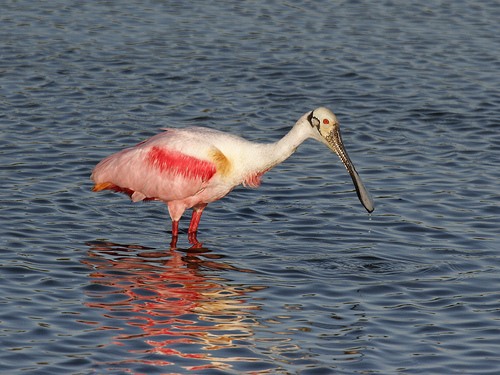

In [4]:
img_name = 'water-bird.JPEG'

pil_img = PIL.Image.open(img_name)
pil_img

画像の前処理をします。サイズを224×224にリサイズして正規化

In [5]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

Grad-GAMの様子を比較するためモデルを５種類取得

In [6]:
alexnet = models.alexnet(pretrained=True)
vgg = models.vgg16(pretrained=True)
resnet = models.resnet101(pretrained=True)
densenet = models.densenet161(pretrained=True)
squeezenet = models.squeezenet1_1(pretrained=True)

各モデルの勾配を取得するレイヤーを設定

In [7]:
configs = [
    dict(model_type='alexnet', arch=alexnet, layer_name='features_11'),
    dict(model_type='vgg', arch=vgg, layer_name='features_29'),
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
    dict(model_type='densenet', arch=densenet, layer_name='features_norm5'),
    dict(model_type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation')
]

勾配と勾配を元の画像に重ね合わせるための関数を設定

In [8]:
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

各モデルのGrad-CAMの様子を可視化して確認

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


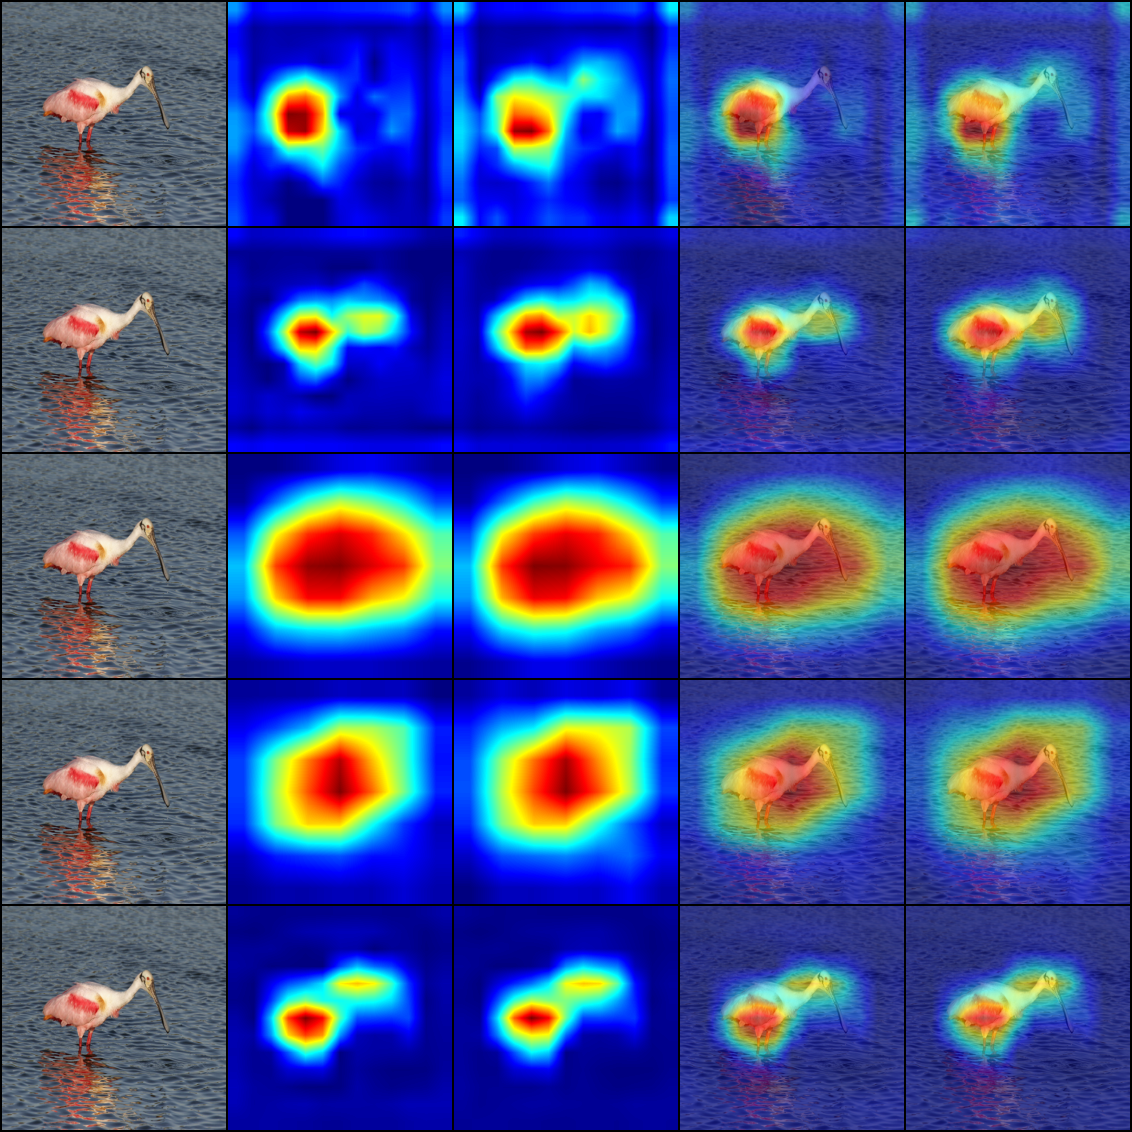

In [9]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)
transforms.ToPILImage()(grid_image)

In [10]:
# 勾配を取得するレイヤーを浅くする
configs = [
    dict(model_type='alexnet', arch=alexnet, layer_name='features_0'),
    dict(model_type='vgg', arch=vgg, layer_name='features_0'),
    dict(model_type='resnet', arch=resnet, layer_name='layer1'),
    dict(model_type='densenet', arch=densenet, layer_name='features_norm0'),
    dict(model_type='squeezenet', arch=squeezenet, layer_name='features_3_expand3x3_activation')
]

In [11]:
# 勾配と勾配を元の画像に重ね合わせるための関数を設定
for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


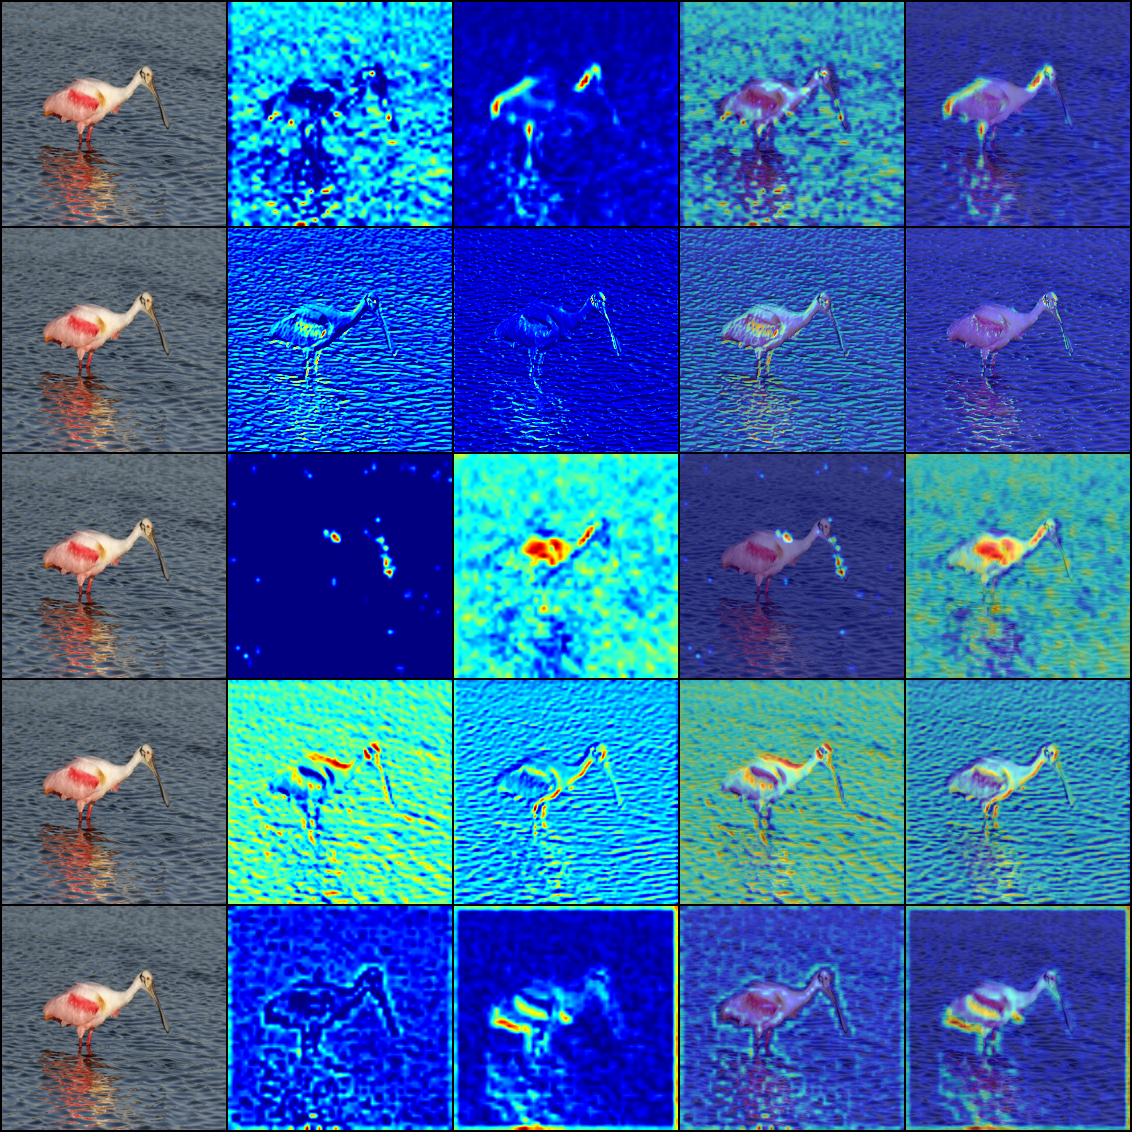

In [12]:
# 同様に可視化
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)

transforms.ToPILImage()(grid_image)